<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_TF_simple
This is a bare minimum version of GREMLIN re-written to work with keras + tensorflow (v1 and v2).

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <koo@cshl.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

## Load some libraries

In [0]:
import numpy as np
import matplotlib.pylab as plt

### OPTIONAL
upgrade to tensorflow 2.0

In [3]:
%%bash
pip -q uninstall --yes tensorflow
pip -q install tensorflow-gpu

## Convert FASTA to MSA np.array()

In [0]:
def parse_fasta(filename):
  '''function to parse fasta file'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {}
  for a,n in zip(alphabet,range(states)):
    a2n[a] = n

  def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']
  
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa)
  return msa_ori, np.eye(states)[msa_ori]

## load example

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [6]:
names,seqs = parse_fasta("4FAZA.fas")
msa_ori, msa = mk_msa(seqs)

print(msa_ori.shape)
print(msa.shape)

(817, 62)
(817, 62, 21)


### compute weight for each sequence

In [0]:
from scipy.spatial.distance import pdist,squareform
def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  # pairwise identity
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

  # weight for each sequence
  msa_w = (msa_sm >= eff_cutoff).astype(np.float)
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

In [0]:
# compute weight for each sequence in the MSA
msa_weights = get_eff(msa_ori)

## GREMLIN
GREMLIN is technically an "autoencoder" with a single dense (or fully-connected) layer between the input and output.
GREMLIN minimizes the difference between the input and output. The "latent" variables are the (w)eights/(b)ias of the dense layer.

* loss = categorical_crossentropy(msa,  softmax(dot(msa, w) + b))
 - the math is identical to computing the "pseudolikelihood" as in GREMLIN()
 
* msa
 - msa.shape = (batch, L x 21)
 - 21 =  (20 amino acids + 1 gap) categories
* w = weight
 - w.shape = (L x 21, L x 21)
 -  aka two-body term of the MRF (aka co-evolution)
 -  note: the w matrix is symmetrized and the diagional is set to zero
* b = bias 
 - b.shape = (L x 21)
 - aka one-body-term of the MRF (aka conservation)

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Zeros, Constant
from tensorflow.keras.losses import categorical_crossentropy

In [0]:
def GREMLIN_simple(msa, msa_weights=None, lam=0.01, batch_size=None, epochs=100):
  
  # [N]umber of sequences, [L]ength, and size of [A]lphabet
  N,L,A = msa.shape
    
  # reset any open sessions/graphs
  K.clear_session()
  
  #############################
  # the model
  #############################  
  # constraints
  def cst_w(x):
    '''symmetrize, set diagonal to zero'''
    x = (x + K.transpose(x))/2    
    zero_mask = K.constant((1-np.eye(L))[:,None,:,None],dtype=tf.float32)
    x = K.reshape(x,(L,A,L,A)) * zero_mask
    return K.reshape(x,(L*A,L*A))
  
  # initialiation
  if msa_weights is None:
    Neff = N
    pssm = msa.sum(0)
  else:
    Neff = msa_weights.sum()
    pssm = (msa.T*msa_weights).sum(-1).T
  
  ini_v = np.log(pssm + lam*np.log(Neff))
  ini_v = Constant(ini_v - ini_v.mean(-1,keepdims=True))
  ini_w = Zeros
  
  # regularization
  lam_v = l2(lam/N)
  lam_w = l2(lam*0.5*(L-1)*(A-1)/N)
  
  # model
  model = Sequential()
  model.add(Flatten(input_shape=(L,A)))
  model.add(Dense(units=L*A,
                  kernel_initializer=ini_w,
                  kernel_regularizer=lam_w,
                  kernel_constraint=cst_w,
                  bias_initializer=ini_v,
                  bias_regularizer=lam_v)) 
  model.add(Reshape((L,A)))
  
  #############################
  # loss function
  #############################
  @tf.function
  def CCE(true,pred):
    '''CCE = -Pseudolikelihood'''
    return K.sum(categorical_crossentropy(true,pred,from_logits=True),axis=-1)     
  
  #############################
  # fit model
  #############################
  learning_rate = 0.1 * np.log(Neff)/L
  model.compile(Adam(learning_rate),CCE)
  
  if batch_size is None: batch_size = N
  opt = dict(x=msa, y=msa, sample_weight=msa_weights, verbose=False)
  
  print(f"loss: {model.evaluate(**opt) * N}")
  model.fit(**opt, batch_size=batch_size, epochs=epochs)    
  print(f"loss: {model.evaluate(**opt) * N}")
  
  #############################
  # return weights
  #############################
  w,v = model.get_weights()
  return v.reshape((L,A)), w.reshape((L,A,L,A))

In [16]:
%%time
V,W = GREMLIN_simple(msa,msa_weights)

loss: 51135.13776779175
loss: 26911.78024673462
CPU times: user 3.25 s, sys: 320 ms, total: 3.57 s
Wall time: 2.78 s


## get contacts

In [0]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:-1,:,:-1]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

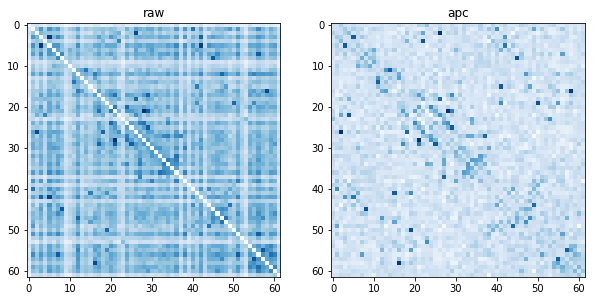

In [18]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(raw, cmap='Blues'); plt.title("raw")
plt.subplot(1,2,2); plt.imshow(apc, cmap='Blues'); plt.title("apc")
plt.show()